# ViVAE workflow for cytometry data

This tutorial covers a simple ViVAE analysis pipeline for the Samusik bone marrow CyTOF dataset (DOI: [10.1038/nmeth.3863]((https://pubmed.ncbi.nlm.nih.gov/27183440/))) (from [HDCytoData](https://www.bioconductor.org/packages/release/data/experiment/html/HDCytoData.html)).

We demonstrate multiple layers of evaluation and interpretability.

In this notebook we

- load and preprocess expression data from our dataset of interest

- create a 2-dimensional embedding of the data using ViVAE and UMAP

- map of manually labelled populations onto embedded points

- compute and plot encoder indicatrices to quantify local distortions of the ViVAE latent space

- run a FlowSOM (meta)clustering and map the FlowSOM tree onto our ViVAE embedding

- use ViScore to asses local and global structure preservation and compare ViVAE to UMAP

<hr>

First let's load all required packages.
In addition to ViVAE, we will want the following...

*FlowSOM* for clustering:
```
pip install git+https://github.com/saeyslab/FlowSOM_Python.git
```

UMAP as an alternative dimension-reduction method:
```
pip install umap-learn==0.5.5
```

ViScore for objective structure-preservation scoring:
```
conda install --channel conda-forge pyemd==1.0.0
pip install git+https://github.com/saeyslab/ViScore.git
```

In [1]:
import numpy as np
import torch
import vivae as vv
import umap
import flowsom as fs
import viscore as vs

INFO:vivae:initialised with "cpu" backend and determinism enabled
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.

### **1.** Data import and pre-processing

We first import our input FCS file and use an $arcsinh$ transformation to pre-process fluorophore signals.

In [2]:
ff       = fs.io.read_FCS('../cytometry_data/Samusik.fcs')
col_idcs = np.arange(8, 47) # column indices of markers of interest
ff       = ff[:,col_idcs]
cofactor = 5.
for channel in range(ff.shape[1]):
    ff[:,channel].X = np.arcsinh(ff[:,channel].X/cofactor)
exprs   = np.asarray(ff.X) # extracted expression data

/var/folders/dq/kfj02tc94z1f_z3jfq1y_8p80000gn/T/ipykernel_29322/1783652828.py:6: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  ff[:,channel].X = np.arcsinh(ff[:,channel].X/cofactor)


We also have manually assigned cell labels available for this dataset.

In [3]:
labels   = np.load('../cytometry_data/Samusik_annot.npy', allow_pickle=True)

Let's build a *k*-nearest-neighbour graph (*k*-NNG) and use it for data denoising.
We do this to boost local structure preservation in ViVAE downstream.

In [4]:
knn     = vv.make_knn(x=exprs, fname=f'../cytometry_data/Samusik_knn.npy') # if k-NNG already exists, it is loaded
exprs_d = vv.smooth(exprs, knn, k=100, coef=1., n_iter=1)

Loading k-NNG


### **2.** Dimensionality reduction

Next we set up a ViVAE model: a parametric dimension-reduction model based on a regularised variational autoencoder (VAE).

We train it to learn a non-linear transformation of our high-dimensional (HD) data into a lower-dimensional (LD) smooth latent space, achieving structure-preserving dimensionality reduction.

The training is done using a combined loss function consisting of three terms:

- **reconstruction error**: measures reconstruction of original data by decoder from LD representation sampled from the latent space

- **KL-divergence from latent prior**: divergence from isotropic Gaussian latent prior using reparametrisation to maintain a smooth latent space (read more [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important))

- **MDS (quartet) loss**: for joint optimisation of relative intra-quartet distances between repeatedly and randomly sampled points (see [SQuadMDS](https://dial.uclouvain.be/pr/boreal/object/boreal:264665) for original idea behind this); **for cytometry data we typically set the weight of this loss to 10 (vs. the other two errors)**

There are many training options.
You can read about them in the documentation by running:
```
help(ViVAE.ViVAE)
```

Some tips on hyperparameter tuning:

- Increase number of epochs (`n_epochs`) for better convergence or decrease it for shorter running times.

- Increase batch size (`batch_size`) for faster training, decrease it for less memory usage.

- Optimiser parameters (`learning_rate` and `weight_decay`) can be increased to speed up training, at the risk of instability and sub-optimal solutions.

In [5]:
np.random.seed(42)
torch.manual_seed(42)
model = vv.ViVAE(input_dim=exprs.shape[1], latent_dim=2)
model.fit(exprs_d, n_epochs=50, lam_mds=10.)

Epoch 1/50	recon: 149.7965	kldiv: 12.8895	geom: 0.0000	egeom: 0.0000	mds: 256.6117	imit: 0.0000
Epoch 2/50	recon: 20.9584	kldiv: 6.7938	geom: 0.0000	egeom: 0.0000	mds: 48.1766	imit: 0.0000
Epoch 3/50	recon: 10.5847	kldiv: 4.2390	geom: 0.0000	egeom: 0.0000	mds: 30.9943	imit: 0.0000
Epoch 4/50	recon: 7.0813	kldiv: 3.1068	geom: 0.0000	egeom: 0.0000	mds: 23.1847	imit: 0.0000
Epoch 5/50	recon: 5.1580	kldiv: 2.4664	geom: 0.0000	egeom: 0.0000	mds: 18.5761	imit: 0.0000
Epoch 6/50	recon: 3.9177	kldiv: 2.0623	geom: 0.0000	egeom: 0.0000	mds: 15.3688	imit: 0.0000
Epoch 7/50	recon: 3.1129	kldiv: 1.7546	geom: 0.0000	egeom: 0.0000	mds: 13.1212	imit: 0.0000
Epoch 8/50	recon: 2.5629	kldiv: 1.5278	geom: 0.0000	egeom: 0.0000	mds: 11.3664	imit: 0.0000
Epoch 9/50	recon: 2.1607	kldiv: 1.3705	geom: 0.0000	egeom: 0.0000	mds: 10.1527	imit: 0.0000
Epoch 10/50	recon: 1.8747	kldiv: 1.2190	geom: 0.0000	egeom: 0.0000	mds: 9.0635	imit: 0.0000
Epoch 11/50	recon: 1.6528	kldiv: 1.1129	geom: 0.0000	egeom: 0.0000	mds: 8.

We can now easily obtain a 2-dimensional embedding of our dataset and plot it using a colour scheme for points based on the manually assigned cell populations we imported earlier.

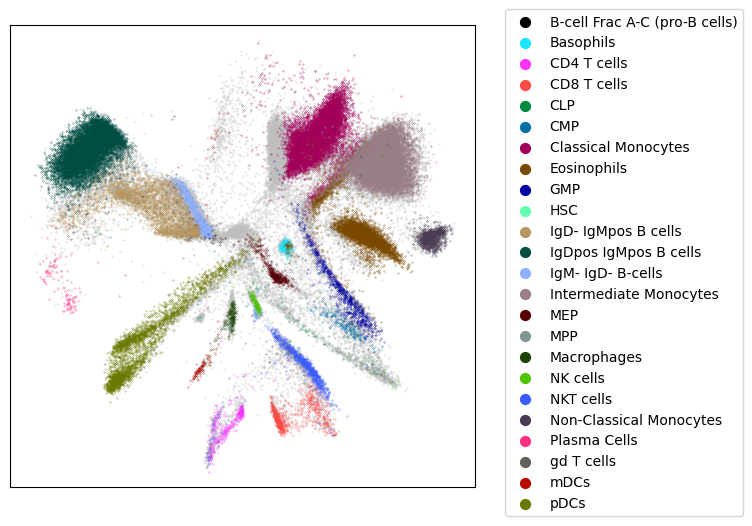

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [6]:
emb = model.transform(exprs_d)
vv.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned')

### **3.** Integration with FlowSOM

FlowSOM is one of the go-to methods for analyses of cytometry datasets.
Thanks to this, many researchers are used to interpreting the outputs of FlowSOM analyses.
If you are one of them, you can apply a FlowSOM analysis to the original expression data and see how concordant the ViVAE embedding is with your FlowSOM tree.

First, let's train a FlowSOM model using the imported FCS file.

In [7]:
fsom = fs.FlowSOM(ff, n_clusters=40, xdim=10, ydim=10, seed=42) # train FlowSOM model

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
2025-04-29 19:04:17.556 | DEBUG    | flowsom.main:__init__:82 - Reading input.
/Users/davidnovak/m

We can now check how the minimum spanning tree (MST) from FlowSOM maps onto our embedding.

It is easy to plot the composition of each cluster in terms of manually defined populations, the expression of one or more markers of interest in each cluster or the mapping of each node to its cluster/metacluster.

The code below shows compositions of clusters in terms of defined populations.
(Set the `fsom_plot_unassigned` argument to include unlabelled cells in the pie charts.)

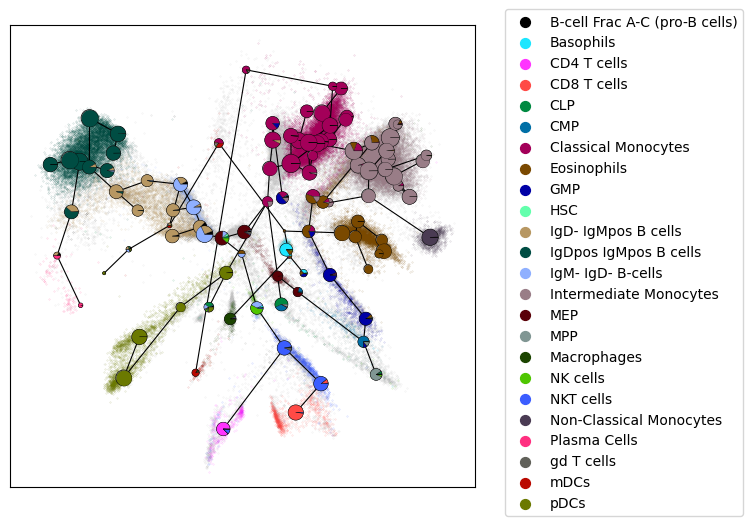

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [8]:
vv.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model)

We can also plot relative expression of multiple selected markers of interest, as shown below.

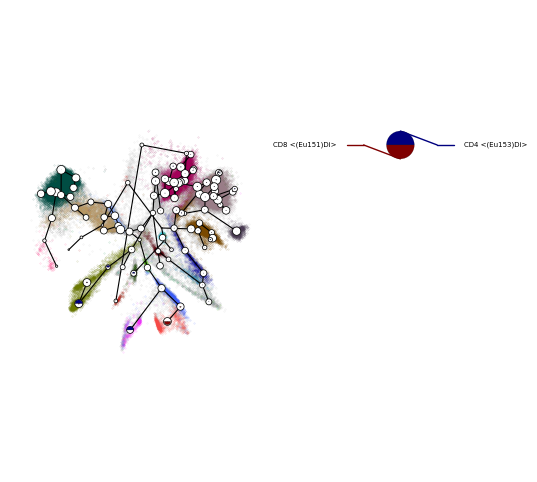

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [9]:
vv.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model, fsom_view='markers', fsom_markers=['CD4', 'CD8'])

If we are interested in only a single marker, the plot becomes simpler.

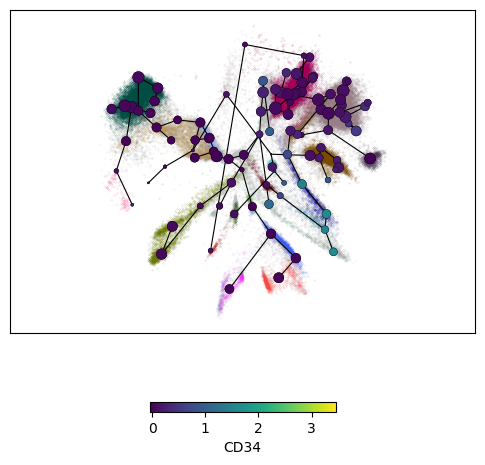

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [10]:
vv.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model, fsom_view='markers', fsom_markers=['CD34'])

We can also plot metacluster numbers, which can be practical for downstream analyses on the metacluster level (eg. differential expression analyses).

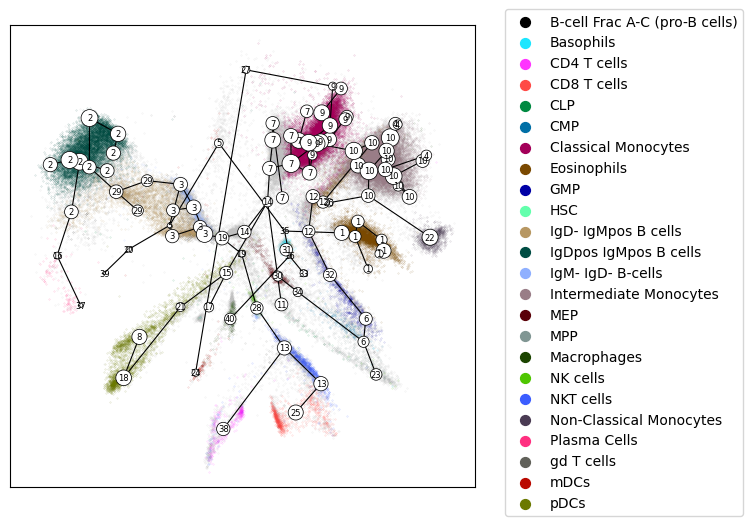

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [11]:
vv.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model, fsom_view='metaclusters')

You can read about all the FlowSOM plotting options in the documentation:
```
help(ViVAE.plot_embedding)
```

### **4.** Encoder indicatrices

Furthermore, we compute and plot the encoder indicatrices, *ie.* objective indicators of local directed stretching of the latent space.
These are based on, but separate and different from, decoder indicatrices as implemented in *Geometric Autoencoders* (DOI: [arXiv:2306.17638](https://arxiv.org/abs/2306.17638)).

Indicatrices are small, equally large hyperspheres in the original, high-dimensional (HD) space (they lie in the [horizontal tangent spaces](https://gemini.google.com/share/9d567cee0c08) of existing data points).

As they are passed through the encoder, they can get distorted in two different ways.
Firstly, their size can vary across the embedding, including relative stretching or contraction of some parts of the points cloud.
Secondly, their shape can change (from sphere to ellipsis), which indicates the specific direction along which the distortion occurs.

In [12]:
ei_nice = model.encoder_indicatrices(X=exprs_d, radius=1e-3, n_steps=50, n_polygon=200)

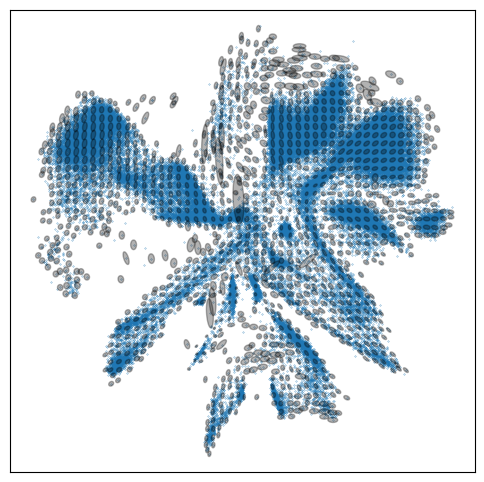

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [13]:
vv.plot_indicatrices(indicatrices=ei_nice, scale_factor=8e1, figsize=(6,6))

The hyperspheres should have a small radius (`radius` in `model.encoder_indicatrices`), but not so small that the resulting shapes in the plot have sharp, as opposed to smooth, edges.

If the radius is set too large, the resulting plot may show a deformed elliptical, C-like or S-like shape in place of an ellipsis.

This is because the hyperspheres reach too far away from the data points and capture deformation outside the horizontal tangent space.
Such a visualisation is typically less informative.

In [14]:
ei_large = model.encoder_indicatrices(X=exprs_d, radius=1e2, n_steps=50, n_polygon=200)

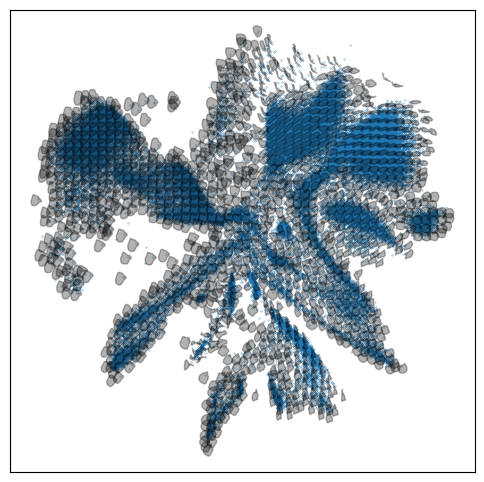

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [15]:
vv.plot_indicatrices(indicatrices=ei_large, scale_factor=3e-3, figsize=(6,6))

If the radius is set too small, the edges of the hyperspheres will appear sharp, as opposed to smooth.

In [16]:
ei_small = model.encoder_indicatrices(X=exprs_d, radius=1e-6, n_steps=50, n_polygon=200)

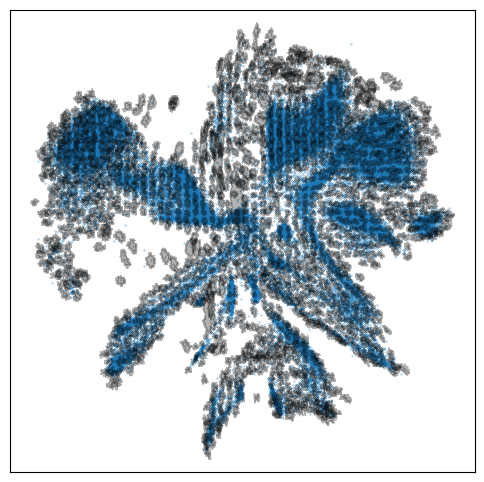

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [17]:
vv.plot_indicatrices(indicatrices=ei_small, scale_factor=1e5, figsize=(6,6))

Note that the `scale_factor` in `plot_indicatrices` needs to be adapted for a good plot (*ie.* indicatrices should be plotted large enough to be informative, but small enough to not have too much overlap).

These are some additional arguments you can alter:

- `n_steps` in `encoder_indicatrices` determines the density of indicatrices (which are sampled on a grid). Higher values will ensure better coverage of the space, but cause a more cluttered plot.

- `n_polygon` in `encoder_indicatrices` determined how many points per indicatrix are sampled. Higher values will ensure higher-quality graphical output, but may increase running time if extremely high.

Note that encoder indicatrices can be implemented for any encoder (*ie.* differentiable dimension-reducing models).

### **5.** Objective evaluation of structure preservation

ViScore allow us to evaluate Local and Global Structure Preservation (SP).
This is achieved through accurate approximation of $R_{NX}$ curves, making it possible to measure multi-scale structure preservation in an objective manner, even for large datasets for which this was previously impossible.

Let's create a UMAP embedding of the same dataset and compare the performance of UMAP and of ViVAE.

In [18]:
model_umap = umap.UMAP()
model_umap.fit(exprs)
emb_umap = model_umap.transform(exprs)

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


The ViVAE plotting function can be used to display the UMAP embedding also.
Since this implementation of UMAP has a `.transform` method (*ie.* new points can be embedded into the latent space after training), we can even map the same FlowSOM tree onto the embedding as well.

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


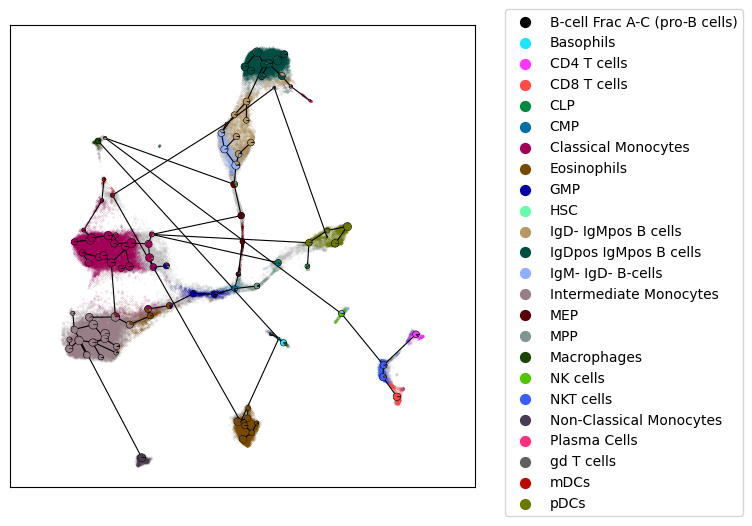

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [19]:
vv.plot_embedding(emb_umap, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model_umap)

Finally, let's compute Local and Global Structure Preservation (SP) for the UMAP and the ViVAE embedding.

In [20]:
## Compare embeddings w.r.t. original input into each method
s_vivae = vs.score(hd=exprs, ld=emb)
s_umap  = vs.score(hd=exprs, ld=emb_umap)

In [21]:
## Report ViVAE and UMAP scores
print(f'ViVAE:\n\tLocal SP:\t{s_vivae["Sl"]:.3f}\n\tGlobal SP:\t{s_vivae["Sg"]:.3f}')
print(f'UMAP:\n\tLocal SP:\t{s_umap["Sl"]:.3f}\n\tGlobal SP:\t{s_umap["Sg"]:.3f}')

ViVAE:
	Local SP:	0.271
	Global SP:	0.598
UMAP:
	Local SP:	0.271
	Global SP:	0.497
